<div style="background-color:#e9eef2; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1);">
    <h1 style="font-size:24px; font-family:calibri; color:#102C42;"><b>Enhanced Model for MRI Brain Tumor Classification</b></h1>
    <p style="font-size:20px; font-family:calibri; line-height: 1.5em; text-indent: 20px;">In this project, we aim to build a robust machine learning model for classifying brain MRI scans into normal and tumor-affected categories, including pituitary, meningioma, and glioma tumors. Given the challenges associated with low-quality medical imaging—particularly in under-resourced settings—our goal is to achieve high diagnostic accuracy even when images are degraded. To address this, we compare transfer learning techniques using pretrained networks with the baseline implementation provided in the referenced paper, assessing their effectiveness in reliably detecting brain tumors under constrained imaging conditions.</p>
</div>

<div style="background-color:#e9eef2; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1);">
    <h1 style="font-size:24px; font-family:calibri; color:#102C42;"><b> Objectives</b></h1>
    <ul style="font-size:20px; font-family:calibri; line-height: 1.5em;">
        <li><strong>Dataset analysis:</strong> Assess class distribution and image dimensions to understand the dataset's structure.</li>
        <li><strong>Handling degraded image quality:</strong> Apply controlled degradation techniques to simulate low-quality imaging conditions and enhance model robustness.</li>
        <li><strong>Transfer learning for enhanced accuracy:</strong> Utilize  pretrained models to achieve high classification accuracy while reducing overfitting on limited data.</li>
        <li><strong>Model Training and Fine-Tuning:</strong> Strategically train and fine-tune both custom and pretrained models for reliable brain tumor classification across all categories.</li>
        <li><strong>Validation and performance assessment:</strong> Evaluate models on a dedicated validation set to ensure generalization and dependable performance, particularly on low-quality MRI images.</li>
    </ul>
</div>



<a id="Initialization"></a>


# **Libraries**

In [ ]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import cv2
from tqdm import tqdm
import random
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import FileLink, display

In [ ]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#e9eef2'}, style='darkgrid')

# **Data Analysis**

Importing data from Kaggle to start the preprocessing

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oulayaelargab","key":"654edde21ac54feee7d5feb6f57cdfb5"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT


In [ ]:
!unzip brain-tumor-classification-mri.zip -d brain_tumor_dataset

Archive:  brain-tumor-classification-mri.zip
  inflating: brain_tumor_dataset/Testing/glioma_tumor/image(1).jpg  
  inflating: brain_tumor_dataset/Testing/glioma_tumor/image(10).jpg  
  inflating: brain_tumor_dataset/Testing/glioma_tumor/image(100).jpg  
  inflating: brain_tumor_dataset/Testing/glioma_tumor/image(11).jpg  
  inflating: brain_tumor_dataset/Testing/glioma_tumor/image(12).jpg  
  inflating: brain_tumor_dataset/Testing/glioma_tumor/image(13).jpg  
  inflating: brain_tumor_dataset/Testing/glioma_tumor/image(14).jpg  
  inflating: brain_tumor_dataset/Testing/glioma_tumor/image(15).jpg  
  inflating: brain_tumor_dataset/Testing/glioma_tumor/image(16).jpg  
  inflating: brain_tumor_dataset/Testing/glioma_tumor/image(17).jpg  
  inflating: brain_tumor_dataset/Testing/glioma_tumor/image(18).jpg  
  inflating: brain_tumor_dataset/Testing/glioma_tumor/image(19).jpg  
  inflating: brain_tumor_dataset/Testing/glioma_tumor/image(2).jpg  
  inflating: brain_tumor_dataset/Testing/gliom

In [ ]:
!ls brain_tumor_dataset

Testing  Training


In [ ]:
!ls brain_tumor_dataset/Training

glioma_tumor  meningioma_tumor	no_tumor  pituitary_tumor


**Exploring the distribution of the dataset**

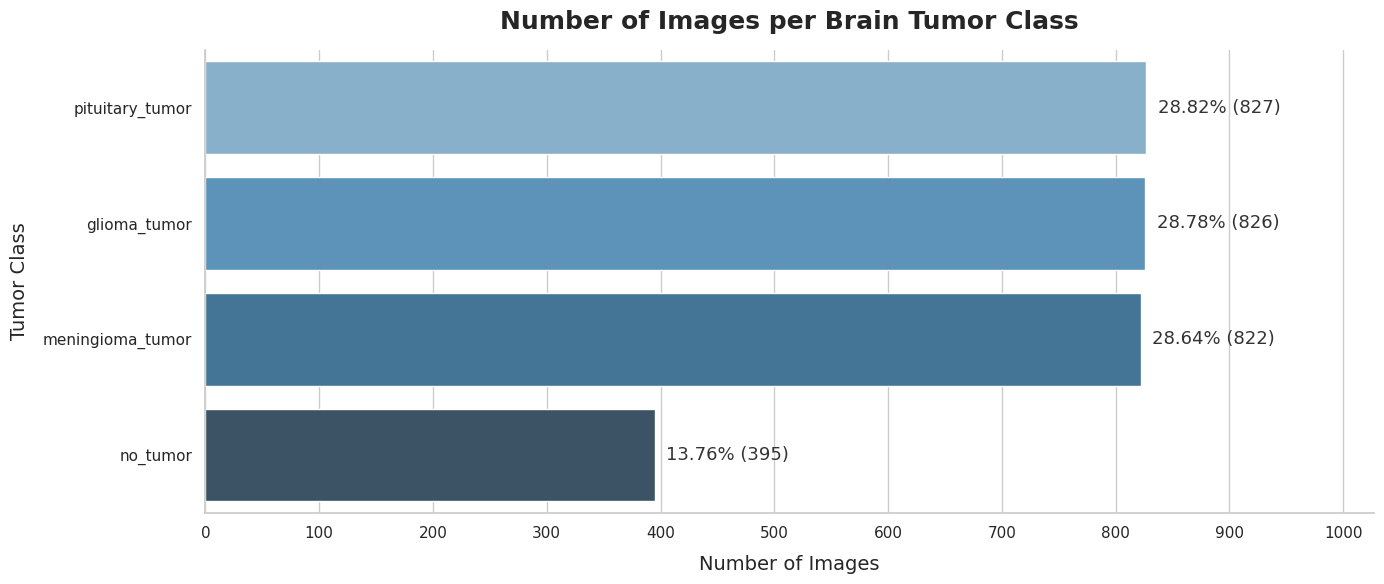

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Directory where the image folders are located
base_dir = '/content/brain_tumor_dataset/Training'

# Get class names from folder names
classes = [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

# Count images per class
counts = [len(os.listdir(os.path.join(base_dir, c))) for c in classes]
total_count = sum(counts)
percentages = [(count / total_count) * 100 for count in counts]

# Sort by counts (optional, for cleaner display)
sorted_data = sorted(zip(classes, counts, percentages), key=lambda x: x[1], reverse=True)
classes, counts, percentages = zip(*sorted_data)

# Set Seaborn style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(y=classes, x=counts, palette="Blues_d")

# Annotate bars
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 10, p.get_y() + p.get_height()/2,
            f'{percentages[i]:.2f}% ({counts[i]})',
            va='center', fontsize=13, color='#333333')

# Axis labels and title
plt.xlabel('Number of Images', fontsize=14, labelpad=10)
plt.ylabel('Tumor Class', fontsize=14, labelpad=10)
plt.title('Number of Images per Brain Tumor Class', fontsize=18, weight='bold', pad=15)

# Custom ticks
ax.set_xticks(range(0, max(counts) + 200, 100))
plt.xlim(0, max(counts) + 200)

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()


<div style="background-color:#e9eef2; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0, 0, 0, 0.1);">
    <h1 style="font-size:24px; font-family:calibri; color:#102C42;"><b> Class Distribution Insights</b></h1>
    <p style="font-size:20px; font-family:calibri; line-height: 1.5em; text-indent: 20px;">
        Given that the 'normal' class is the most underrepresented in the dataset, it poses a challenge for achieving balanced model performance. To address this, careful consideration must be given during training to reduce bias toward the more frequent tumor classes.
    </p>
</div>

In [ ]:
# Initialize lists and sets
heights = []
widths = []
unique_dims = set()

# Loop over each class and its images
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            unique_dims.add((h, w))
            heights.append(h)
            widths.append(w)

# Output summary
if len(unique_dims) == 1:
    print(f" All images have the same dimensions: {list(unique_dims)[0]}")
else:
    print(f" Found {len(unique_dims)} unique image dimensions in the dataset.")
    print(f" Height → Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.2f}")
    print(f" Width  → Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.2f}")


 Found 361 unique image dimensions in the dataset.
 Height → Min: 198, Max: 1446, Mean: 481.42
 Width  → Min: 180, Max: 1375, Mean: 480.11


**Resizing the images**

In [ ]:
# Source and target folders
source_dir = '/content/brain_tumor_dataset/Training'
target_dir = '/content/brain_tumor_dataset/Training-256'
IMG_SIZE = 256

# Create target folder if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

# Get all class folders
class_folders = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

print(f" Resizing images to {IMG_SIZE}x{IMG_SIZE}...")

for cls in class_folders:
    src_cls_path = os.path.join(source_dir, cls)
    tgt_cls_path = os.path.join(target_dir, cls)

    os.makedirs(tgt_cls_path, exist_ok=True)

    for img_name in tqdm(os.listdir(src_cls_path), desc=f"Processing {cls}"):
        src_img_path = os.path.join(src_cls_path, img_name)
        tgt_img_path = os.path.join(tgt_cls_path, img_name)

        try:
            img = cv2.imread(src_img_path)
            if img is not None:
                resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
                cv2.imwrite(tgt_img_path, resized)
        except Exception as e:
            print(f" Failed to process {img_name} in {cls}: {e}")
            continue

print(f"All images resized and saved to: {target_dir}")


 Resizing images to 256x256...


Processing glioma_tumor: 100%|██████████| 826/826 [00:02<00:00, 276.31it/s]

✅ All images resized and saved to: /content/brain_tumor_dataset/Training-256


In [ ]:
# Path to resized dataset
resized_dir = '/content/brain_tumor_dataset/Training-256'

# Rebuild class list from folder names
classes = [folder for folder in os.listdir(resized_dir) if os.path.isdir(os.path.join(resized_dir, folder))]

# Storage for size stats
heights = []
widths = []
unique_dims = set()

# Loop through all images
for class_name in classes:
    folder_path = os.path.join(resized_dir, class_name)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            unique_dims.add((h, w))
            heights.append(h)
            widths.append(w)

# Report
if len(unique_dims) == 1:
    print(f" All images resized correctly to: {list(unique_dims)[0]}")
else:
    print(f" Found {len(unique_dims)} different sizes")
    print(f"Min Height: {min(heights)}, Max Height: {max(heights)}, Mean: {np.mean(heights):.2f}")
    print(f"Min Width : {min(widths)}, Max Width : {max(widths)}, Mean: {np.mean(widths):.2f}")

 All images resized correctly to: (256, 256)


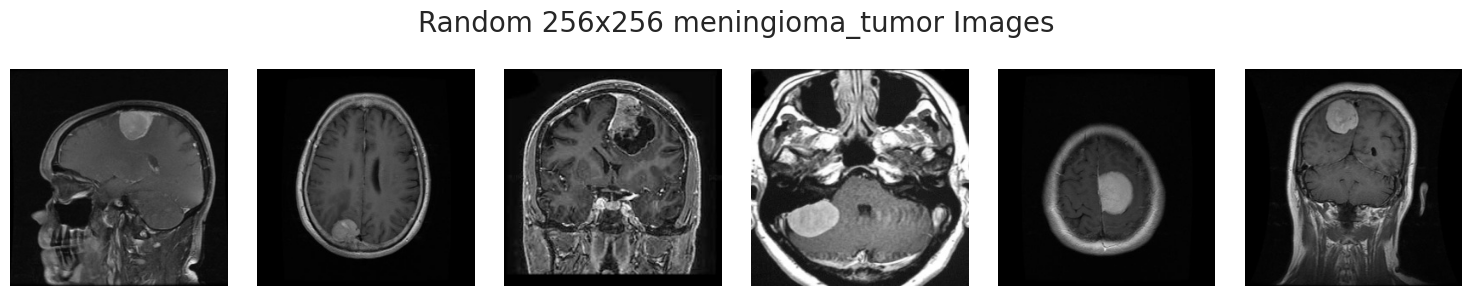

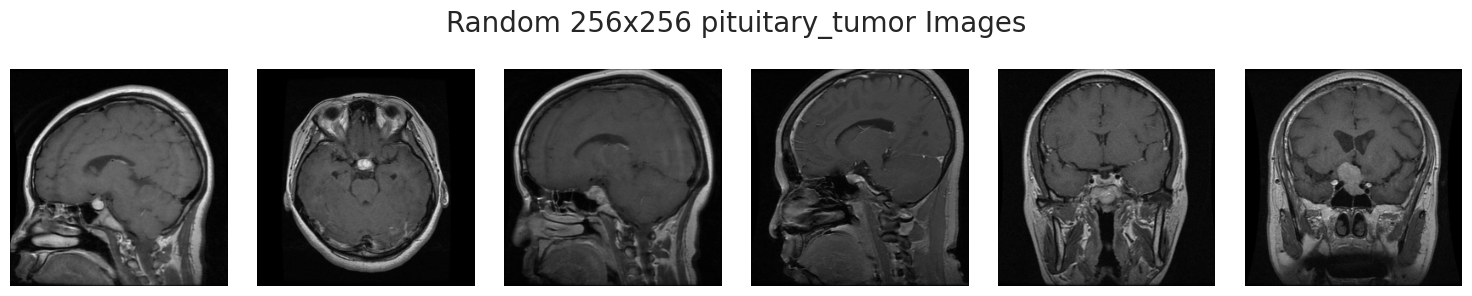

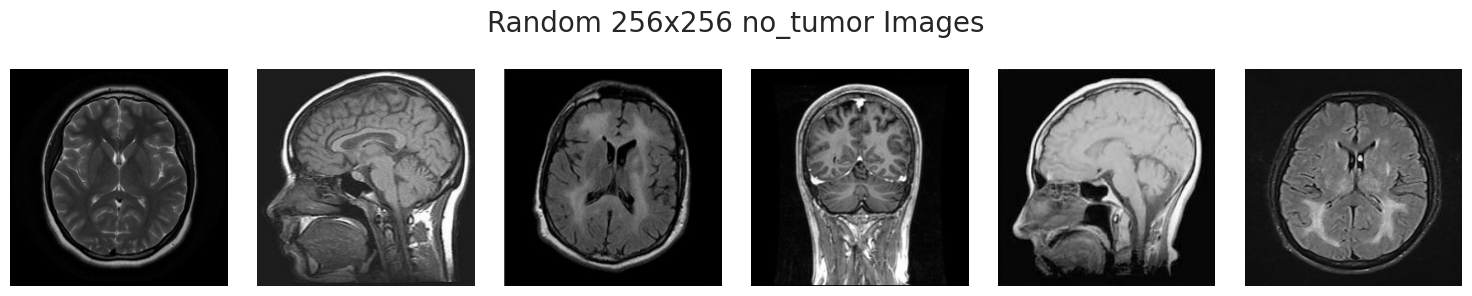

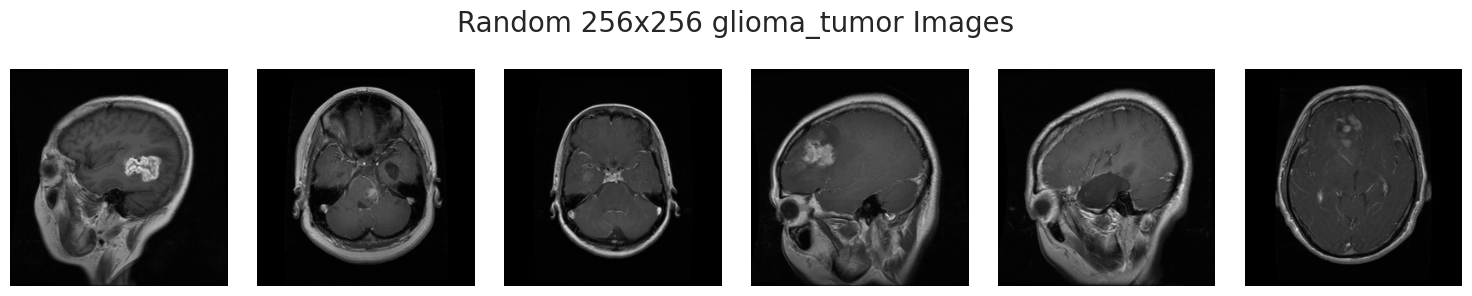

In [ ]:
# Set base_dir to resized dataset
base_dir = '/content/brain_tumor_dataset/Training-256'

# Rebuild class list from resized folders
classes = [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

def plot_images(images, title):
    plt.figure(figsize=(15, 3))
    for i, img_path in enumerate(images):
        plt.subplot(1, 6, i + 1)  # 1 row, 6 columns
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Plot 6 random resized images per class
np.random.seed(42)  # for reproducibility

for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]

    if len(all_images) >= 6:
        random_images = np.random.choice(all_images, 6, replace=False)
        plot_images(random_images, f"Random 256x256 {class_name} Images")
    else:
        print(f" Not enough images in {class_name} to display.")


In [ ]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop over each class and append the image file paths with their respective labels to the data list
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    data.extend([(os.path.join(folder_path, filename), class_name) for filename in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, filename))])

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
df.head()

filepath             label
0  /content/brain_tumor_dataset/Training-256/meni...  meningioma_tumor
1  /content/brain_tumor_dataset/Training-256/meni...  meningioma_tumor
2  /content/brain_tumor_dataset/Training-256/meni...  meningioma_tumor
3  /content/brain_tumor_dataset/Training-256/meni...  meningioma_tumor
4  /content/brain_tumor_dataset/Training-256/meni...  meningioma_tumor

In [ ]:
print("Total number of images:", df.shape[0])

Total number of images: 2870


In [ ]:
# Deleting unnecessary variables to free up memory
del data, all_images

<a id="Split"></a>
# <b><span style='color:#769bb8'> </span><span style='color:#102C42'> Data Splitting into Training & Validation Sets</span></b>


In [ ]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Display the shape of the training and validation sets
print("Training data shape:", train_df.shape)
print("Validation data shape:", val_df.shape)

# Deleting the original DataFrame to free up memory
del df

Training data shape: (2296, 2)
Validation data shape: (574, 2)


In [ ]:
# Display the first few rows of the train DataFrame
train_df.head(10)

filepath             label
2641  /content/brain_tumor_dataset/Training-256/glio...      glioma_tumor
1806  /content/brain_tumor_dataset/Training-256/no_t...          no_tumor
2385  /content/brain_tumor_dataset/Training-256/glio...      glioma_tumor
2540  /content/brain_tumor_dataset/Training-256/glio...      glioma_tumor
328   /content/brain_tumor_dataset/Training-256/meni...  meningioma_tumor
625   /content/brain_tumor_dataset/Training-256/meni...  meningioma_tumor
756   /content/brain_tumor_dataset/Training-256/meni...  meningioma_tumor
1710  /content/brain_tumor_dataset/Training-256/no_t...          no_tumor
999   /content/brain_tumor_dataset/Training-256/pitu...   pituitary_tumor
759   /content/brain_tumor_dataset/Training-256/meni...  meningioma_tumor

In [ ]:
# Display the first few rows of the validation DataFrame
val_df.head(10)

filepath             label
624   /content/brain_tumor_dataset/Training-256/meni...  meningioma_tumor
1656  /content/brain_tumor_dataset/Training-256/no_t...          no_tumor
2590  /content/brain_tumor_dataset/Training-256/glio...      glioma_tumor
517   /content/brain_tumor_dataset/Training-256/meni...  meningioma_tumor
2317  /content/brain_tumor_dataset/Training-256/glio...      glioma_tumor
1404  /content/brain_tumor_dataset/Training-256/pitu...   pituitary_tumor
1708  /content/brain_tumor_dataset/Training-256/no_t...          no_tumor
1615  /content/brain_tumor_dataset/Training-256/pitu...   pituitary_tumor
2606  /content/brain_tumor_dataset/Training-256/glio...      glioma_tumor
2410  /content/brain_tumor_dataset/Training-256/glio...      glioma_tumor

<a id="Augmentation"></a>
# <b><span style='color:#769bb8'></span><span style='color:#102C42'> Augmentation of Dataset with Artificially Degraded Images</span></b>


<div style="background-color:#e9eef2; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0,0,0,0.1);">
    <h1 style="font-size:24px; font-family:calibri; color:#102C42;"><b>Preparing for Low-Quality Image Analysis</b></h1>
    <p style="font-size:20px; font-family:calibri; line-height:1.5em; text-indent:20px;">
        Applying different degradation techniques to simulate the challenging conditions of low-quality MRI scans that occur in real images to enure the high perfomance of the model under these conditions:
    </p>
    <ul style="font-size:20px; font-family:calibri; line-height:1.5em;">
        <li><strong>1️⃣ Adding Noise:</strong> Introducing variations like Gaussian noise noise to replicate common imaging artifacts</li>
        <li><strong>2️⃣ Applying Blur:</strong> Gaussian or motion blur for mimicing the blurring effect caused by patient movement or imaging hardware constraints.</li>
        <li><strong>3️⃣ Downsampling:</strong> Reducing the image resolution to represent the capabilities of less advanced MRI machinery typically found in under-resourced settings.</li>
    </ul>
    <p style="font-size:20px; font-family:calibri; line-height:1.5em; text-indent:20px;">
        
        
  
    
</div>


In [ ]:
def add_gaussian_noise(image, mean=0, std=0.05):
    """ Add Gaussian noise to an image """
    gauss = np.random.normal(mean, std, image.shape)
    noisy_image = image + gauss
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image

In [ ]:
def apply_blur(image, kernel_size=5):
    """ Apply Gaussian blur to an image """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

In [ ]:
def downsample_upsample(image, scale_percent=50):
    """ Downsample and then upsample an image """
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return cv2.resize(resized, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)

<div style="background-color:#e9eef2; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0,0,0,0.1);">
    <p style="font-size:20px; font-family:calibri; line-height:1.5em; text-indent:20px;">
        Total number of images:
    </p>
</div>


In [ ]:
def count_images(dataframe):
    """ Function to count the total number of images in a DataFrame """
    return dataframe.shape[0]

In [ ]:
# Count and print the number of images in the training and validation sets before the modifications
total_train_images = count_images(train_df)
total_val_images = count_images(val_df)

print(f"Total number of training images: {total_train_images}")
print(f"Total number of validation images: {total_val_images}")

Total number of training images: 2296
Total number of validation images: 574


In [ ]:
def augment_images(dataframe, base_dir):
    modified_data = []

    for _, row in dataframe.iterrows():
        img_path = row['filepath']
        label = row['label']
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Randomly apply one or more degradation methods
        choices = ['noise', 'blur', 'downsample']
        chosen_methods = random.sample(choices, k=random.randint(1, len(choices)))

        if 'noise' in chosen_methods:
            img = add_gaussian_noise(img)
        if 'blur' in chosen_methods:
            img = apply_blur(img)
        if 'downsample' in chosen_methods:
            img = downsample_upsample(img)

        # Save the new image with a modified name
        directory, filename = os.path.split(img_path)
        new_img_path = os.path.join(directory, f"modified_{filename}")
        cv2.imwrite(new_img_path, img)

        # Append the new image path and its label to the list
        modified_data.append((new_img_path, label))

    # Create a DataFrame with the modified images and their respective labels
    modified_images_df = pd.DataFrame(modified_data, columns=['filepath', 'label'])

    # Return the updated DataFrame with both original and modified images
    return pd.concat([dataframe, modified_images_df], ignore_index=True)

In [ ]:
# Apply augmentation and update the training and validation datasets
train_df = augment_images(train_df, base_dir)
val_df = augment_images(val_df, base_dir)

<div style="background-color:#e9eef2; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0,0,0,0.1);">
    <p style="font-size:20px; font-family:calibri; line-height:1.5em; text-indent:20px;">
        Number of images after applying the modifications:
    </p>
</div>


In [ ]:
# Count and print the number of images in the training and validation sets after the modifications
total_train_images = count_images(train_df)
total_val_images = count_images(val_df)

print(f"Total number of training images: {total_train_images}")
print(f"Total number of validation images: {total_val_images}")

Total number of training images: 4592
Total number of validation images: 1148


<div style="background-color:#e9eef2; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0,0,0,0.1);">
    <p style="font-size:20px; font-family:calibri; line-height:1.5em; text-indent:20px;">
        Tumors are still visible even after applying the modifications:
    </p>
</div>


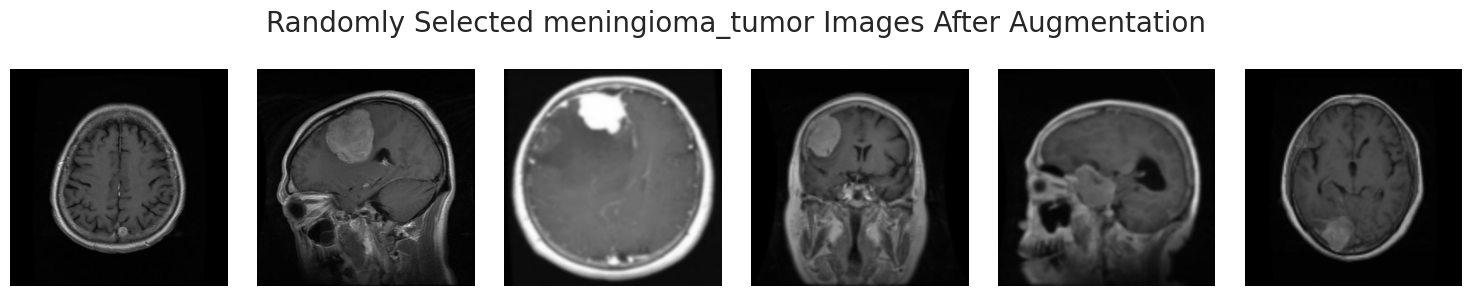

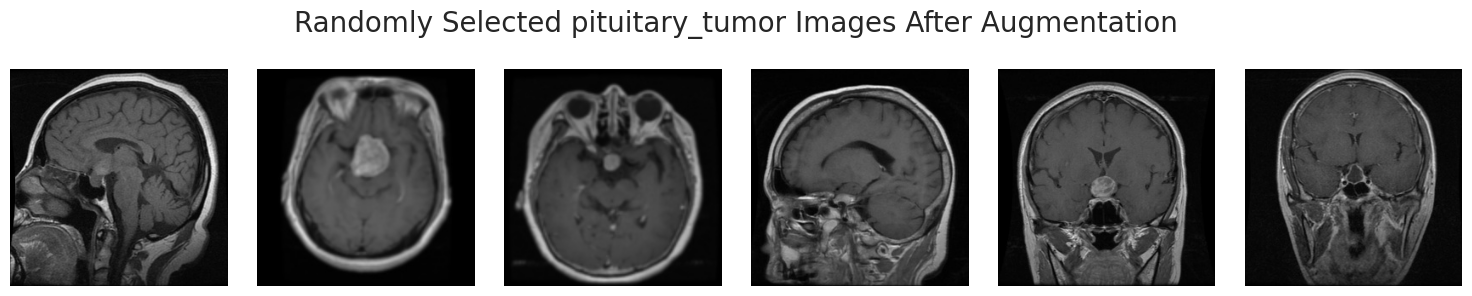

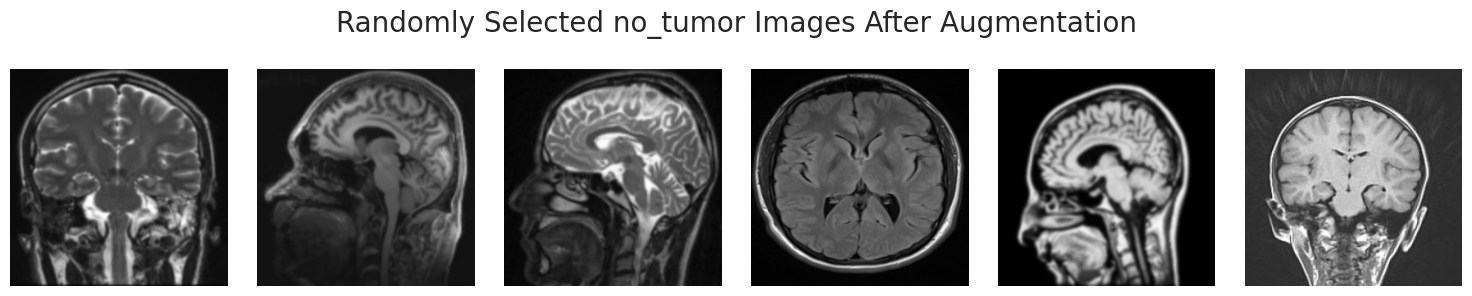

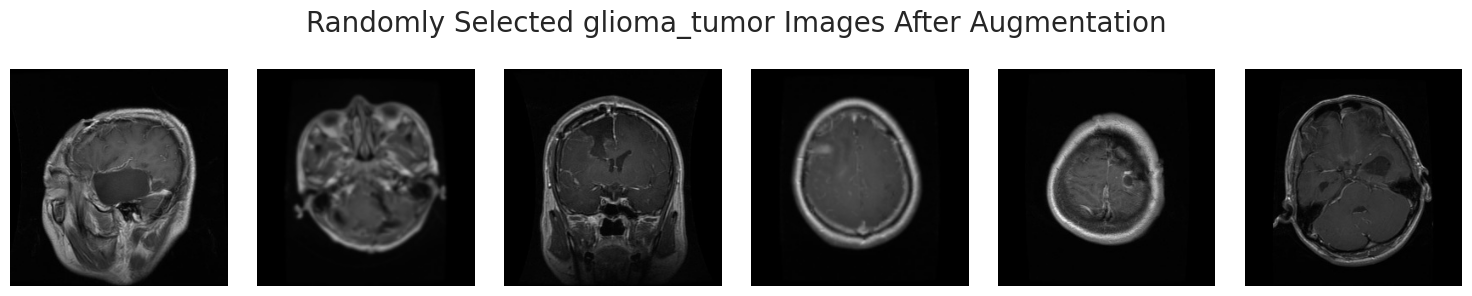

In [ ]:
for class_name in classes:
    folder_path = os.path.join(base_dir, class_name)
    all_images = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]
    random_images = np.random.choice(all_images, 6, replace=False)  # Choose 6 images randomly
    plot_images(random_images, f"Randomly Selected {class_name} Images After Augmentation")

 <a id="Preprocessing"></a>
# <b><span style='color:#769bb8'></span><span style='color:#102C42'> Establishing Data Generators for Model Input</span></b>


<div style="background-color:#e9eef2; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0,0,0,0.1);">
    <p style="font-size:20px; font-family:calibri; line-height:1.5em; text-indent:20px;">
        <ul>
  <li><strong>Dynamic Preprocessing:</strong> Utilized Keras’s <code>ImageDataGenerator</code> to perform real-time image preprocessing and augmentation during training.</li>
  <li><strong>Memory Efficiency:</strong> Enables on-the-fly processing to avoid memory overload from storing augmented images.</li>
  <li><strong>Realistic Augmentations:</strong> Applied small rotations, width/height shifts, zooming, and horizontal flips to simulate real-world MRI variations.</li>
  <li><strong>Preservation of Medical Integrity:</strong> Ensured that all augmentations maintain essential diagnostic features within MRI scans.</li>
  <li><strong>Model-Ready Preprocessing:</strong> The augmentation function is optimized to prepare input data tailored to the neural network architecture.</li>
</ul>

   
</div>

In [ ]:
def create_data_generators(train_df, val_df, preprocessing_function=None, batch_size=32, image_dimensions=(224, 224)):

     # Define the training data generator with appropriate augmentations
    train_datagen = ImageDataGenerator(
        rotation_range=20,                           # Rotate images by up to 20 degrees
        width_shift_range=0.10,                      # Shift images horizontally by up to 10% of their width
        height_shift_range=0.10,                     # Shift images vertically by up to 10% of their height
        zoom_range=0.10,                             # Zoom in/out by up to 10%
        horizontal_flip=True,                        # Allow horizontal flipping
        preprocessing_function=preprocessing_function
    )

    # Define the validation data generator without any augmentations
    val_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function
    )

    # Create an iterable generator for training data
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,                 # DataFrame containing training data
        x_col="filepath",                   # Column with paths to image files
        y_col="label",                      # Column with image labels
        target_size=image_dimensions,       # Resize all images to size of 224x224
        batch_size=batch_size,              # Number of images per batch
        class_mode='categorical',           # Specify multi-class classification task
        seed=42,                            # Seed for random number generator to ensure reproducibility
        shuffle=True                        # Shuffle the data to ensure the model gets a randomized batch during training
    )

    # Create an iterable generator for validation data
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,                   # DataFrame containing validation data
        x_col="filepath",
        y_col="label",
        target_size=image_dimensions,
        batch_size=batch_size,
        class_mode='categorical',           # Specify multi-class classification task
        seed=42,
        shuffle=False                       # Shuffling not necessary for validation data
    )

    # Return the training and validation generators
    return train_generator, val_generator

In [ ]:
# Create the data generators
train_generator, val_generator = create_data_generators(train_df, val_df, preprocessing_function=preprocess_input)

# Fetch a batch of images and labels
batch_images, batch_labels = next(train_generator)

# Check the shape of the first image in the batch
print("Shape of the first image in the batch:", batch_images[0].shape)

Found 4592 validated image filenames belonging to 4 classes.
Found 1148 validated image filenames belonging to 4 classes.
Shape of the first image in the batch: (224, 224, 3)


In [ ]:
# Retrieve the class names
class_indices = train_generator.class_indices

# Sorting the class indices to get the list of class names in the correct order
class_names = sorted(class_indices, key=class_indices.get)
class_names

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

<div style="background-color:#e9eef2; padding: 20px; border-radius: 10px; box-shadow: 0 2px 4px 0 rgba(0,0,0,0.1);">
    <h1 style="font-size:24px; font-family:calibri; color:#102C42;"><b> Validation Performance Review</b></h1>
    <p style="font-size:20px; font-family:calibri; line-height:1.5em; text-indent:20px;">
        Plots of loss and accuracy trends, along with confusion matrices, are used to evaluate the performance of the models in detecting tumors on low-quality images.
    </p>
</div>


In [ ]:
def plot_learning_curves(history, start_epoch=5):

    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
    df = df.iloc[start_epoch-1:]

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='#102C42', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='#102C42', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

In [ ]:
def evaluate_model_performance(model, val_generator, class_labels):

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "#102C42"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

#**VGG16 baseline model from the paper** adapted with tensorflow

In [ ]:
def build_vgg16_script(input_shape=(224, 224, 3), num_classes=4):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers
    for layer in base_model.layers:
        layer.trainable = False

    # Match script logic: just add Dense(4) without extra hidden layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model


In [ ]:
def train_model(model, train_df, val_df, preprocessing_function=None, image_dimensions=(224, 224), batch_size=32, num_epochs=20):
    train_gen, val_gen = create_data_generators(
        train_df, val_df,
        preprocessing_function=preprocessing_function,
        batch_size=batch_size,
        image_dimensions=image_dimensions
    )

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    ]

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_gen,
        steps_per_epoch=len(train_gen),
        validation_data=val_gen,
        validation_steps=len(val_gen),
        epochs=num_epochs,
        callbacks=callbacks
    )

    return model, history, val_gen


In [ ]:
# Build and compile the VGG16 model from the original script
model_vgg16_script = build_vgg16_script(input_shape=(224, 224, 3), num_classes=4)
model_vgg16_script.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using your dataframe and VGG preprocessing
model_vgg16_script, history_vgg16_script, val_gen_vgg16_script = train_model(
    model_vgg16_script,
    train_df,
    val_df,
    preprocessing_function=preprocess_input,  # VGG16 expects this
    image_dimensions=(224, 224),
    num_epochs=20
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Found 4592 validated image filenames belonging to 4 classes.
Found 1148 validated image filenames belonging to 4 classes.
Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 97s 587ms/step - accuracy: 0.2927 - loss: 2.9777 - val_accuracy: 0.3310 - val_loss: 2.0955 - learning_rate: 1.0000e-04
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 472ms/step - accuracy: 0.3828 - loss: 1.9776 - val_accuracy: 0.4477 - val_loss: 1.5858 - learning_rate: 1.0000e-04
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 472ms/step - accuracy: 0.4590 - loss: 1.6203 - val_accuracy: 0.5348 - val_loss: 1.2804 - learning_rate: 1.0000e-04
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 71s 496ms/step - accuracy: 0.4951 - loss: 1.4618 - val_accuracy: 0.6167 - val_loss: 1.0771 - learning_rate: 1.0000e-04
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 78s 466ms/step - accuracy: 0.5640 - loss: 1.1908 - val_accuracy: 0.6437 - val_loss: 0.9504 - learning_rate: 1.0000e-04
Epoch 6/20
144/144 ━━━━━━━━━━━━━

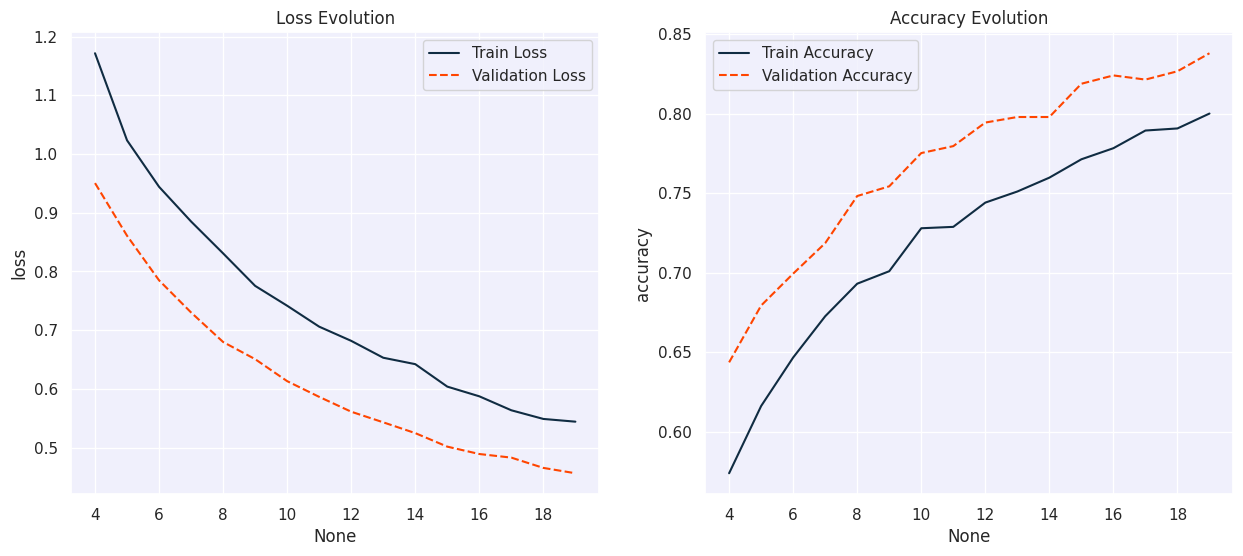

In [ ]:
plot_learning_curves(history_vgg16_script, start_epoch=5)

36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.81      0.85      0.83       330
meningioma_tumor       0.76      0.74      0.75       330
        no_tumor       0.91      0.82      0.86       158
 pituitary_tumor       0.91      0.94      0.93       330

        accuracy                           0.84      1148
       macro avg       0.85      0.84      0.84      1148
    weighted avg       0.84      0.84      0.84      1148





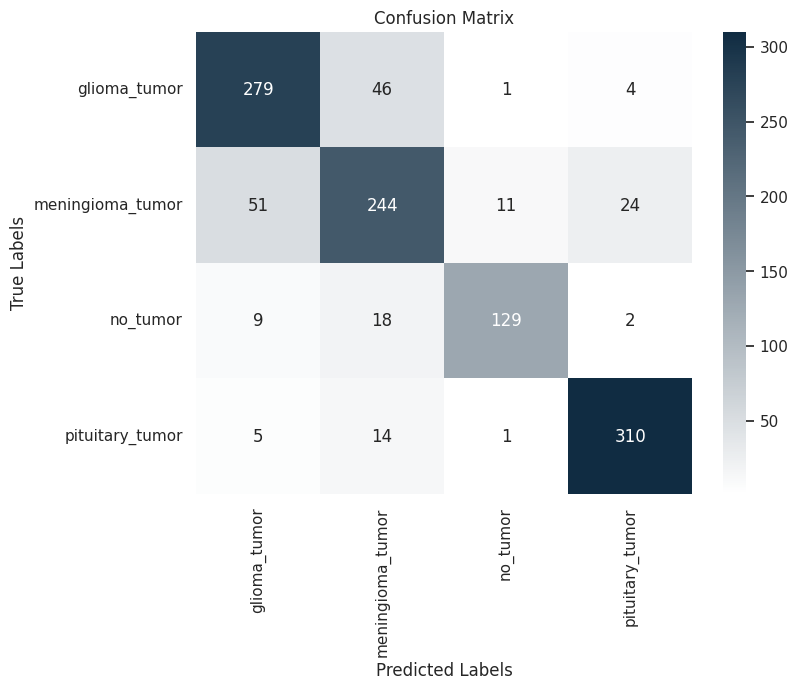

In [ ]:
evaluate_model_performance(model_vgg16_script, val_gen_vgg16_script, classes)

## **Pretrained VGG16** Enhanced version


In [ ]:
# Pretrained VGG16 Model

def build_pretrained_vgg16(input_shape=(224, 224, 3), num_classes=4):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Training the Model

def train_model(model, train_df, val_df, batch_size=32, num_epochs=20, image_dimensions=(224, 224)):


    train_gen, val_gen = create_data_generators(
        train_df, val_df,
        preprocessing_function=preprocess_input,  # VGG16 expects this
        batch_size=batch_size,
        image_dimensions=image_dimensions
    )

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    ]

    history = model.fit(
        train_gen,
        steps_per_epoch=len(train_gen),
        validation_data=val_gen,
        validation_steps=len(val_gen),
        epochs=num_epochs,
        callbacks=callbacks
    )

    return model, history, val_gen

# Runing


# 1. Build and compile the model
modelvgg16 = build_pretrained_vgg16(input_shape=(224, 224, 3), num_classes=4)
modelvgg16.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# 2. Visualize the model architecture (optional)
plot_model(modelvgg16, show_shapes=True, show_layer_names=False, dpi=200)

# 3. Train the model
modelvgg16, historyvgg16, val_generatorvgg16 = train_model(modelvgg16, train_df, val_df, num_epochs=20)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Found 4592 validated image filenames belonging to 4 classes.
Found 1148 validated image filenames belonging to 4 classes.
Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 96s 582ms/step - accuracy: 0.3855 - loss: 2.5246 - val_accuracy: 0.7570 - val_loss: 0.6697 - learning_rate: 1.0000e-04
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 125s 537ms/step - accuracy: 0.6080 - loss: 1.0940 - val_accuracy: 0.8023 - val_loss: 0.5550 - learning_rate: 1.0000e-04
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 71s 459ms/step - accuracy: 0.6954 - loss: 0.7867 - val_accuracy: 0.8171 - val_loss: 0.4805 - learning_rate: 1.0000e-04
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 65s 452ms/step - accuracy: 0.7535 - loss: 0.6716 - val_accuracy: 0.8284 - val_loss: 0.4563 - learning_rate: 1.0000e-04
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 83s 456ms/step - accuracy: 0.7673 - loss: 0.6178 - val_accuracy: 0.8484 - val_loss: 0.4252 - learning_rate: 1.0000e-04
Epoch 6/20
144/144 ━━━━━━━━━━━━

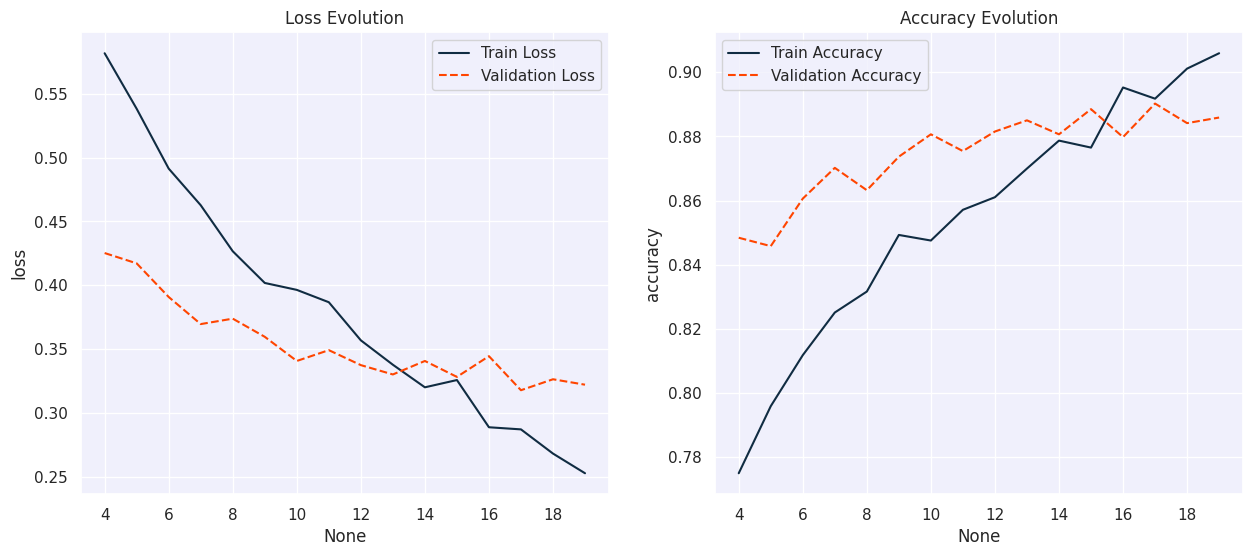

In [ ]:
plot_learning_curves(historyvgg16, start_epoch=5)

36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.90      0.90       330
meningioma_tumor       0.85      0.82      0.84       330
        no_tumor       0.91      0.88      0.89       158
 pituitary_tumor       0.90      0.96      0.93       330

        accuracy                           0.89      1148
       macro avg       0.89      0.89      0.89      1148
    weighted avg       0.89      0.89      0.89      1148





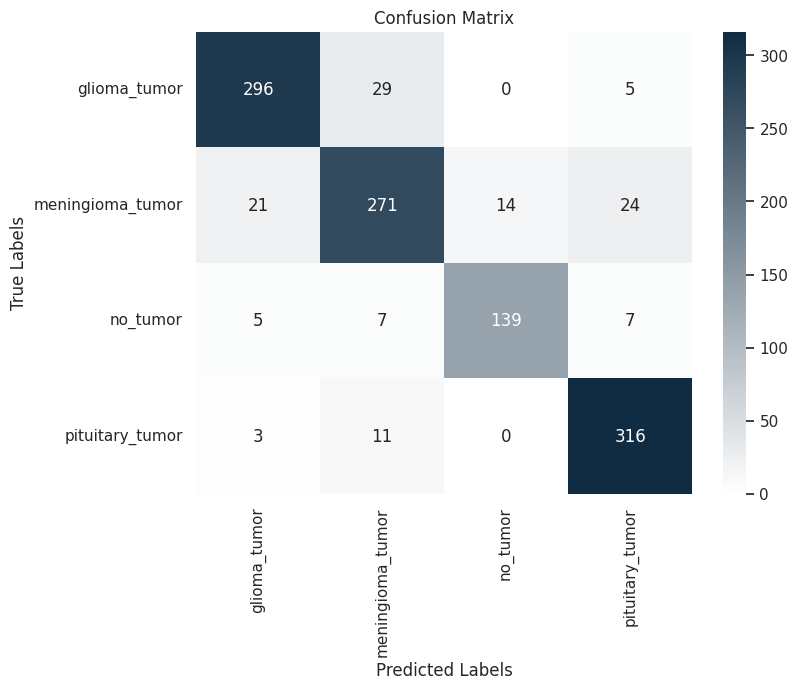

In [ ]:
evaluate_model_performance(modelvgg16, val_generatorvgg16, classes)

# **VGG19 baseline model from the paper** adapted with tensorflow

In [ ]:
def build_vgg19_script(input_shape=(224, 224, 3), num_classes=4):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all base layers
    for layer in base_model.layers:
        layer.trainable = False

    # Only add Dense(4) like the original script (no hidden layers)
    x = GlobalAveragePooling2D()(base_model.output)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model


In [ ]:
def train_model(model, train_df, val_df, preprocessing_function=None, image_dimensions=(224, 224), batch_size=32, num_epochs=20):
    train_gen, val_gen = create_data_generators(
        train_df, val_df,
        preprocessing_function=preprocessing_function,
        batch_size=batch_size,
        image_dimensions=image_dimensions
    )

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    ]

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_gen,
        steps_per_epoch=len(train_gen),
        validation_data=val_gen,
        validation_steps=len(val_gen),
        epochs=num_epochs,
        callbacks=callbacks
    )

    return model, history, val_gen


In [ ]:
# Build and compile the VGG19 model
model_vgg19_script = build_vgg19_script(input_shape=(224, 224, 3), num_classes=4)
model_vgg19_script.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


# Train it using dataframe + preprocessing
model_vgg19_script, history_vgg19_script, val_gen_vgg19_script = train_model(
    model_vgg19_script,
    train_df,
    val_df,
    preprocessing_function=preprocess_input,
    image_dimensions=(224, 224),
    num_epochs=20
)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Found 4592 validated image filenames belonging to 4 classes.
Found 1148 validated image filenames belonging to 4 classes.
Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 105s 634ms/step - accuracy: 0.3110 - loss: 3.3253 - val_accuracy: 0.3763 - val_loss: 1.7780 - learning_rate: 1.0000e-04
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 110s 494ms/step - accuracy: 0.4007 - loss: 1.7093 - val_accuracy: 0.4634 - val_loss: 1.4268 - learning_rate: 1.0000e-04
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 82s 497ms/step - accuracy: 0.4901 - loss: 1.3822 - val_accuracy: 0.5305 - val_loss: 1.1950 - learning_rate: 1.0000e-04
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 72s 499ms/step - accuracy: 0.5521 - loss: 1.1872 - val_accuracy: 0.5897 - val_loss: 1.0415 - learning_rate: 1.0000e-04
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 73s 508ms/step - accuracy: 0.5836 - loss: 1.0953 - val_accuracy: 0.6324 - val_loss: 0.9284 - learning_rate: 1.0000e-04
Epoch 6/20
144/144 ━━━━━━━━━━━

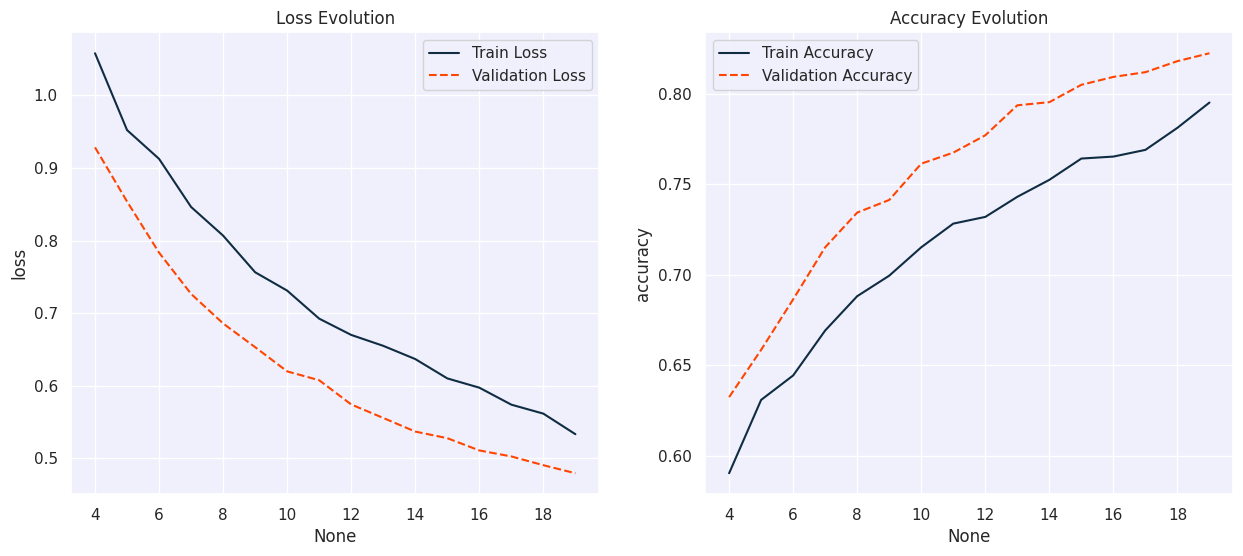

In [ ]:
plot_learning_curves(history_vgg19_script, start_epoch=5)

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.82      0.83      0.83       330
meningioma_tumor       0.74      0.73      0.74       330
        no_tumor       0.90      0.82      0.86       158
 pituitary_tumor       0.86      0.91      0.89       330

        accuracy                           0.82      1148
       macro avg       0.83      0.82      0.83      1148
    weighted avg       0.82      0.82      0.82      1148





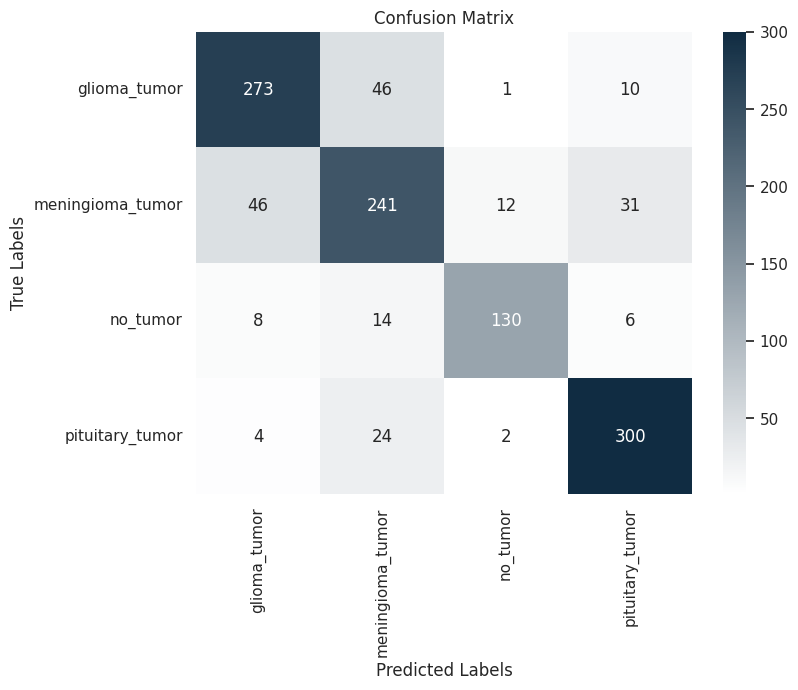

In [ ]:
evaluate_model_performance(model_vgg19_script, val_gen_vgg19_script, classes)

# **Pretrained VGG19** Enhanced version

In [ ]:
#Pretrained VGG19 Model
def build_pretrained_vgg19(input_shape=(224, 224, 3), num_classes=4):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all base layers
    base_model.trainable = False

    # Add custom classification head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model


# Training the Model

def train_model(model, train_df, val_df, preprocessing_function=None, image_dimensions=(224, 224), batch_size=32, num_epochs=20):
    train_gen, val_gen = create_data_generators(
        train_df, val_df,
        preprocessing_function=preprocessing_function,
        batch_size=batch_size,
        image_dimensions=image_dimensions
    )

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    ]

    history = model.fit(
        train_gen,
        steps_per_epoch=len(train_gen),
        validation_data=val_gen,
        validation_steps=len(val_gen),
        epochs=num_epochs,
        callbacks=callbacks
    )

    return model, history, val_gen

# Runing


# Build and compile the model
modelvgg19 = build_pretrained_vgg19(input_shape=(224, 224, 3), num_classes=4)
modelvgg19.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
modelvgg19, historyvgg19, val_generatorvgg19 = train_model(modelvgg19, train_df, val_df, preprocessing_function=preprocess_input, num_epochs=20)

Found 4592 validated image filenames belonging to 4 classes.
Found 1148 validated image filenames belonging to 4 classes.
Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 103s 611ms/step - accuracy: 0.3721 - loss: 2.2460 - val_accuracy: 0.7378 - val_loss: 0.6861 - learning_rate: 1.0000e-04
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 473ms/step - accuracy: 0.6266 - loss: 1.0176 - val_accuracy: 0.8023 - val_loss: 0.5755 - learning_rate: 1.0000e-04
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 82s 474ms/step - accuracy: 0.6898 - loss: 0.7869 - val_accuracy: 0.8049 - val_loss: 0.5498 - learning_rate: 1.0000e-04
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 469ms/step - accuracy: 0.7176 - loss: 0.7093 - val_accuracy: 0.8118 - val_loss: 0.5180 - learning_rate: 1.0000e-04
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 82s 468ms/step - accuracy: 0.7446 - loss: 0.6234 - val_accuracy: 0.8223 - val_loss: 0.4718 - learning_rate: 1.0000e-04
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 471ms/step - accuracy: 0.7771 - loss: 

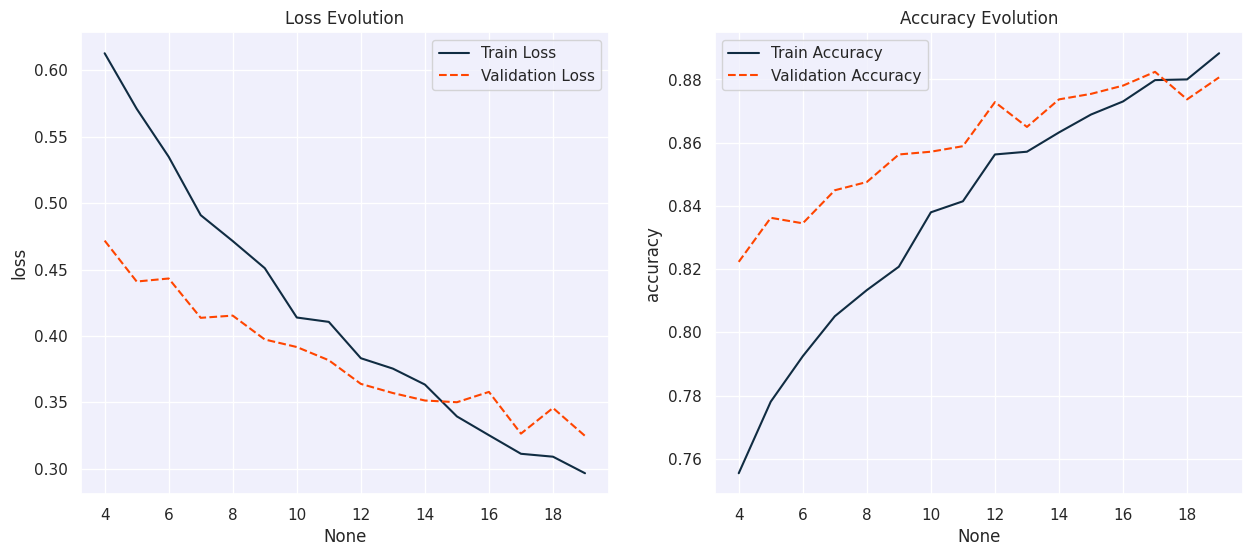

In [ ]:
plot_learning_curves(historyvgg19, start_epoch=5)

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.84      0.88       330
meningioma_tumor       0.78      0.86      0.82       330
        no_tumor       0.96      0.87      0.91       158
 pituitary_tumor       0.92      0.95      0.94       330

        accuracy                           0.88      1148
       macro avg       0.89      0.88      0.89      1148
    weighted avg       0.89      0.88      0.88      1148





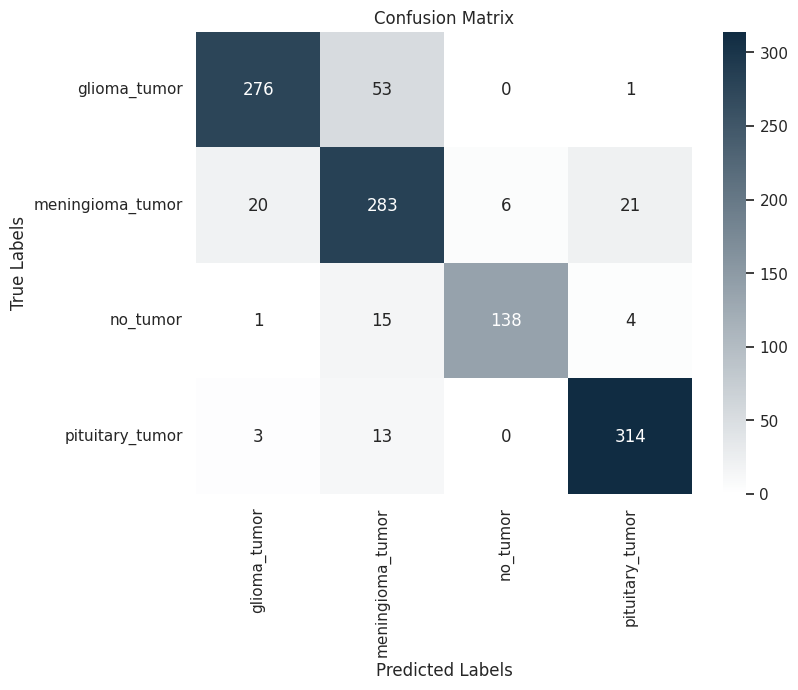

In [ ]:
evaluate_model_performance(modelvgg19, val_generatorvgg19, classes)

# **ResNet50V2 baseline model from the paper** adapted with tensorflow

In [ ]:
def build_resnet50_script(input_shape=(224, 224, 3), num_classes=4):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze all layers (you can change to fine-tune later)
    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D(name='avg_pool')(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

In [ ]:
def train_model(model, train_df, val_df, preprocessing_function=None, image_dimensions=(224, 224), batch_size=32, num_epochs=20):
    train_gen, val_gen = create_data_generators(
        train_df, val_df,
        preprocessing_function=preprocessing_function,
        batch_size=batch_size,
        image_dimensions=image_dimensions
    )

    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    ]

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_gen,
        steps_per_epoch=len(train_gen),
        validation_data=val_gen,
        validation_steps=len(val_gen),
        epochs=num_epochs,
        callbacks=callbacks
    )

    return model, history, val_gen


In [ ]:
# Build and compile the model
model_resnet50_script = build_resnet50_script(input_shape=(224, 224, 3), num_classes=4)
model_resnet50_script.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model_resnet50_script, history_resnet50_script, val_gen_resnet50_script = train_model(
    model_resnet50_script,
    train_df,
    val_df,
    preprocessing_function=preprocess_input,
    image_dimensions=(224, 224),
    num_epochs=20
)


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 4592 validated image filenames belonging to 4 classes.
Found 1148 validated image filenames belonging to 4 classes.
Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 88s 504ms/step - accuracy: 0.5244 - loss: 1.2000 - val_accuracy: 0.8336 - val_loss: 0.4389 - learning_rate: 1.0000e-04
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 59s 402ms/step - accuracy: 0.7728 - loss: 0.5849 - val_accuracy: 0.8528 - val_loss: 0.3778 - learning_rate: 1.0000e-04
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 83s 407ms/step - accuracy: 0.8108 - loss: 0.4669 - val_accuracy: 0.8824 - val_loss: 0.3386 - learning_rate: 1.0000e-04
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 58s 403ms/step - accuracy: 0.8545 - loss: 0.3900 - val_accuracy: 0.8876 - val_loss: 0.3189 - learning_rate: 1.0000e-04
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 59s 407ms/step - accuracy: 0.8552 - loss: 0.3752 - val_accuracy: 0.8972 - val_loss: 0.2982 - learning_rate: 1.0000e-04
Epoch 6/20
144/144 ━━━━━━━━━━━━━

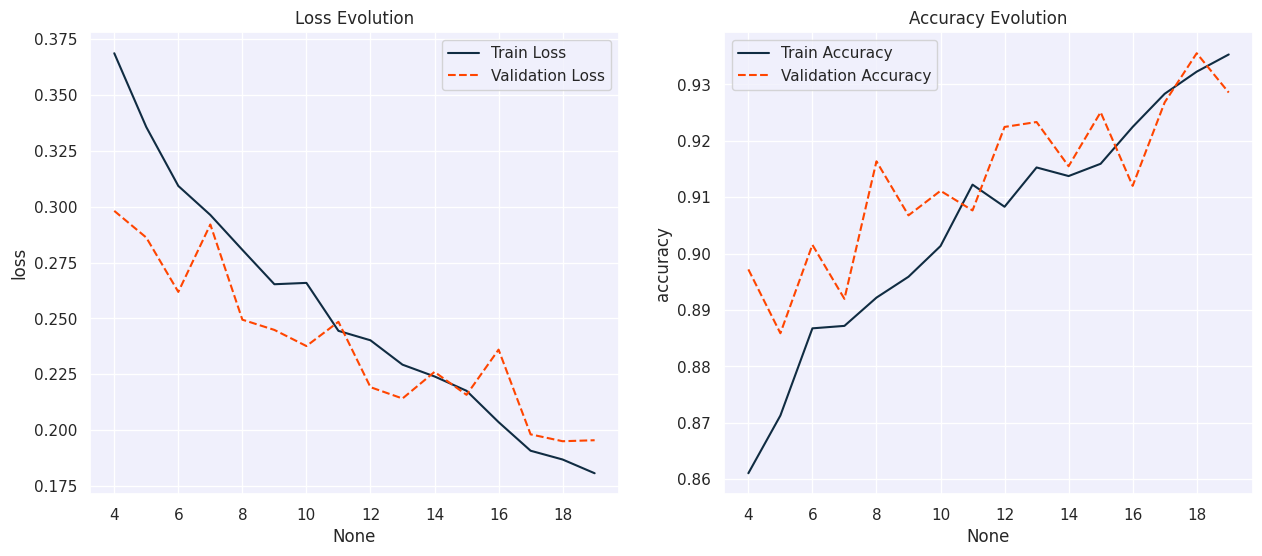

In [ ]:
plot_learning_curves(history_resnet50_script, start_epoch=5)

36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.94      0.94       330
meningioma_tumor       0.91      0.88      0.89       330
        no_tumor       0.96      0.95      0.96       158
 pituitary_tumor       0.94      0.98      0.96       330

        accuracy                           0.94      1148
       macro avg       0.94      0.94      0.94      1148
    weighted avg       0.94      0.94      0.94      1148





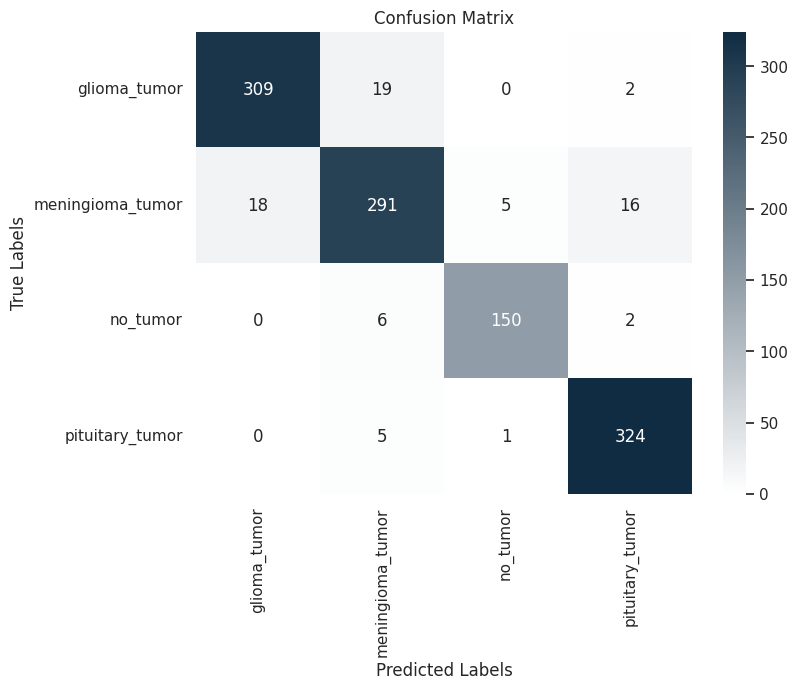

In [ ]:
evaluate_model_performance(model_resnet50_script, val_gen_resnet50_script, classes)

# **Pretrained ResNet50** Enhanced version

In [ ]:
# Load the pre-trained ResNet50V2 model without the top layer
base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout added to prevent overfitting
x = Dense(4, activation='softmax')(x)  # Output layer for multi-class classification

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [ ]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 25,667,076 (97.91 MB)

 Trainable params: 25,621,636 (97.74 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
def train_model(model, train_df, val_df, preprocessing_function, image_dimensions=(224, 224), batch_size=32, num_epochs=50):

    # Create data generators
    train_generator, val_generator = create_data_generators(train_df, val_df, preprocessing_function, batch_size, image_dimensions)

    # Define the callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=num_epochs,
        validation_data=val_generator,
        validation_steps=len(val_generator),
        callbacks=[reduce_lr, early_stopping]
    )

    return model, history, val_generator

In [ ]:
# Fine-tune the model
model, history, val_generator = train_model(model, train_df, val_df, preprocessing_function=preprocess_input, num_epochs=20)

Found 4592 validated image filenames belonging to 4 classes.
Found 1148 validated image filenames belonging to 4 classes.
Epoch 1/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 162s 712ms/step - accuracy: 0.7094 - loss: 0.6823 - val_accuracy: 0.8711 - val_loss: 0.4163 - learning_rate: 1.0000e-04
Epoch 2/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 469ms/step - accuracy: 0.9431 - loss: 0.1737 - val_accuracy: 0.8955 - val_loss: 0.3598 - learning_rate: 1.0000e-04
Epoch 3/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 68s 469ms/step - accuracy: 0.9667 - loss: 0.1018 - val_accuracy: 0.9164 - val_loss: 0.2464 - learning_rate: 1.0000e-04
Epoch 4/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 84s 487ms/step - accuracy: 0.9748 - loss: 0.0727 - val_accuracy: 0.9591 - val_loss: 0.1227 - learning_rate: 1.0000e-04
Epoch 5/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 67s 465ms/step - accuracy: 0.9726 - loss: 0.0742 - val_accuracy: 0.8824 - val_loss: 0.3883 - learning_rate: 1.0000e-04
Epoch 6/20
144/144 ━━━━━━━━━━━━━━━━━━━━ 70s 486ms/step - accuracy: 0.9765 - loss: 

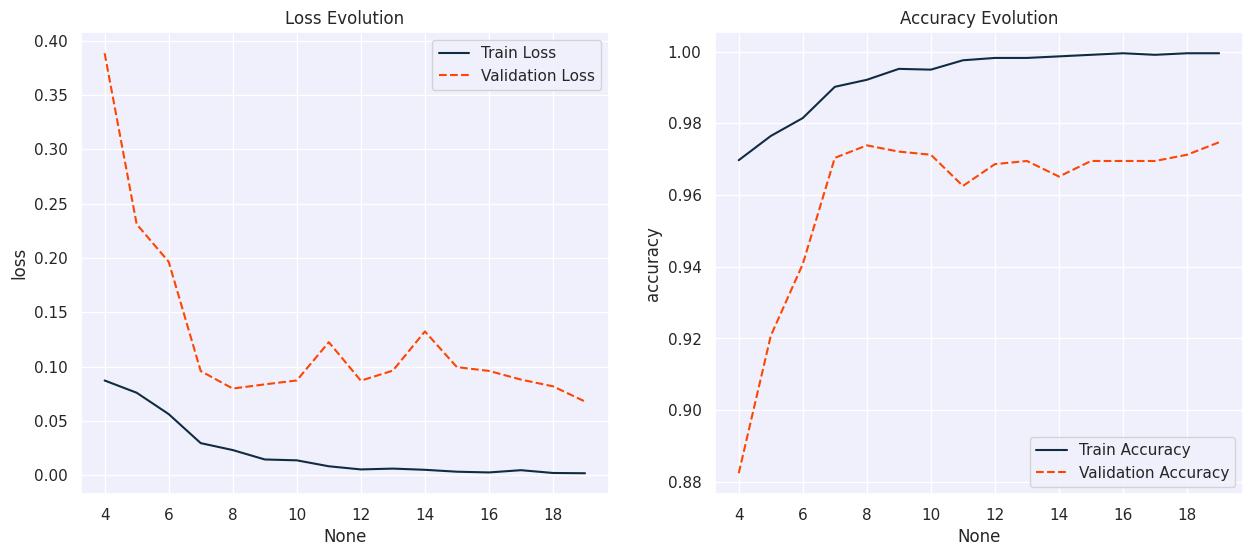

In [ ]:
plot_learning_curves(history)

36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.98      0.97       330
meningioma_tumor       0.98      0.96      0.97       330
        no_tumor       1.00      0.96      0.98       158
 pituitary_tumor       0.97      1.00      0.99       330

        accuracy                           0.97      1148
       macro avg       0.98      0.97      0.98      1148
    weighted avg       0.97      0.97      0.97      1148





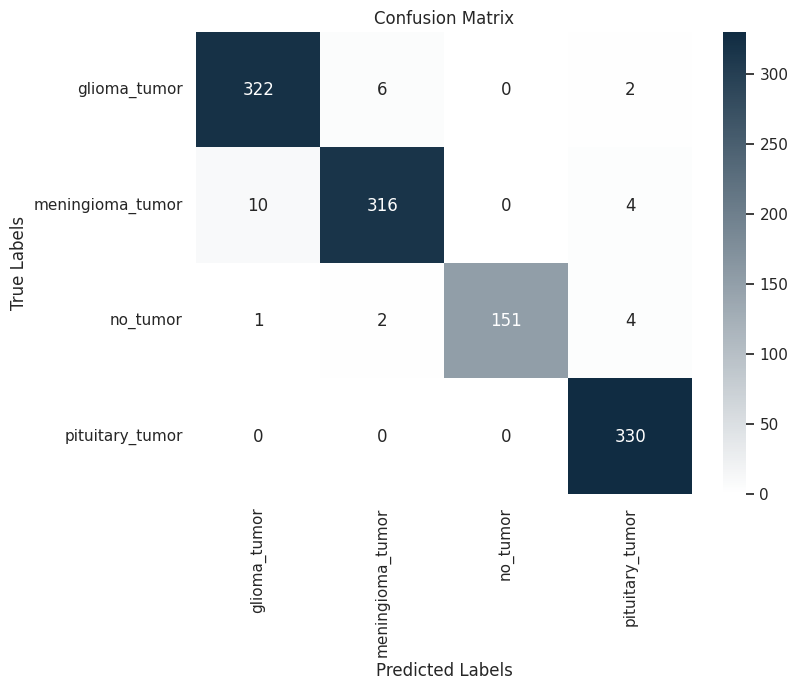

In [ ]:
evaluate_model_performance(model, val_generator, classes)